# Makemore - BatchNorm - Exercises no.3

## Setup and data

### Import packages

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Import data

In [4]:
words = open('../data/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

### Build vocabulary and map to/from integers

In [7]:
chars = sorted(list(set(''.join(words))))
itos = {i+1:s for i, s in enumerate(chars)}
itos[0] = '.'
stoi = {s:i for i, s in itos.items()}
vocab_size = len(itos)

print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Build dataset splits

In [8]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for name in words:
        context = [0] * block_size
        for char in name + '.':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtst, Ytst = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Neural Network

### Layer modules

In [34]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) * 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers
        self.running_mean = torch.ones(dim)
        self.running_var = torch.zeros(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x - xmean) / torch.sqrt(xvar + eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.weight]

class Tanh():

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

### Neural Network initialisation

In [81]:
n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_emb), generator=g)
layers = [
    Linear((block_size * n_emb), n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), Tanh(),
    Linear(            n_hidden, vocab_size)
]

# Make last layer less confident
layers[-1].weight *= 0.1
# Gain on all linear layers
for layer in layers:
    if isinstance(layer, Linear):
        layer.weight *= 1

# Parameters
parameters = [C] + ([p for layer in layers for p in layer.parameters()])
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


### Training loop

In [82]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # Build mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    if i > 1000:
        break

      0 / 200000: 3.2474


## Diagnostics

### Calculate loss per split

In [83]:
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtst, Ytst)
    }[split]

    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)

    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.5208210945129395
val 2.5274739265441895


### Activation Distribution

Plot a figure
Create a list for the legend
Enumerate the layers and for every Tanh layer:
    - Print the layer name, mean, std and saturation as a percentage (abs value above 0,97)
    - Get the histogram data
    - Plot the information
    - Add layer to the legend
Add legend
Add title

layer 1 ( Tanh): mean = -0.07 | std = 0.86 | saturation = 49.23%
layer 3 ( Tanh): mean = +0.00 | std = 0.92 | saturation = 67.21%
layer 5 ( Tanh): mean = +0.01 | std = 0.93 | saturation = 70.19%
layer 7 ( Tanh): mean = -0.01 | std = 0.93 | saturation = 68.28%
layer 9 ( Tanh): mean = -0.05 | std = 0.92 | saturation = 67.17%


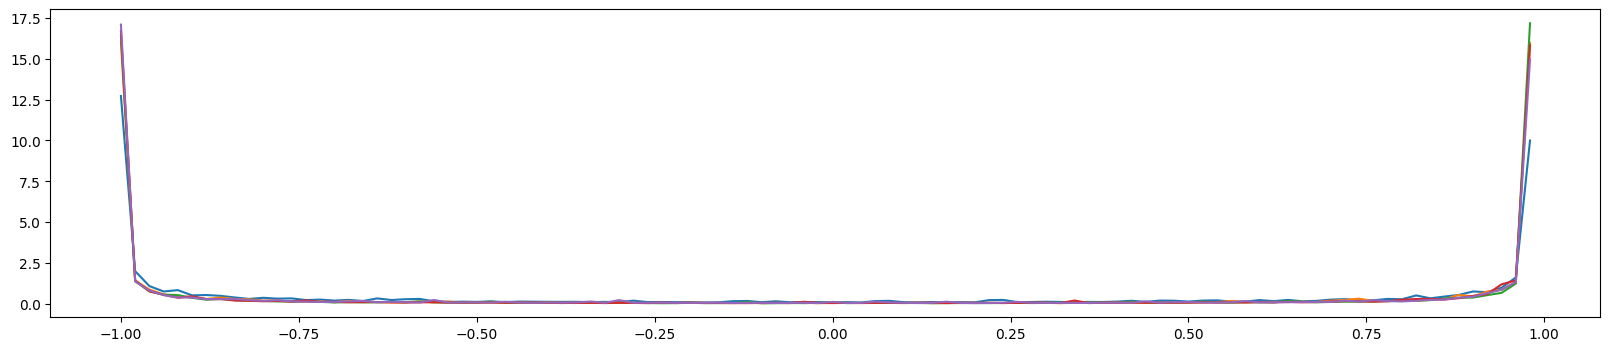

In [84]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%5s): mean = %+.2f | std = %.2f | saturation = %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())

### Gradient Dis

### Weights Gradient Distribution

### Weights Update Ratio